In [113]:
%matplotlib nbagg
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors.kde import KernelDensity
from sklearn.cross_validation import train_test_split
import pandas as pd
from sklearn.linear_model import Ridge
import seaborn as sns
from __future__ import division
from sklearn.metrics import r2_score
from sklearn.preprocessing import scale

In [114]:
plt.close()
df = pd.read_csv("DesignMatrix.csv")
input = df.as_matrix()
X = input[:,1:-1]
Y = input[:,-1:]



In [127]:
X_scaled = scale(X)
#Y_scaled = scale(Y)
#scaler = StandardScaler().fit(X)
#X_trans = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size =500, random_state=5)

In [128]:
print X.shape 
print Y.shape

(3998, 84)
(3998, 1)


### Experiments with sample data generated

In [89]:
mu, sigma = 0, 1.

In [90]:
#Generating design matrix

X = np.random.normal(mu,sigma,300).reshape(100,3)

In [91]:
y = np.random.lognormal(mu, sigma, 100)

In [92]:
y = np.reshape(y,(y.shape[0],1))
y.shape

(100, 1)

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =30, random_state=5)

<IPython.core.display.Javascript object>


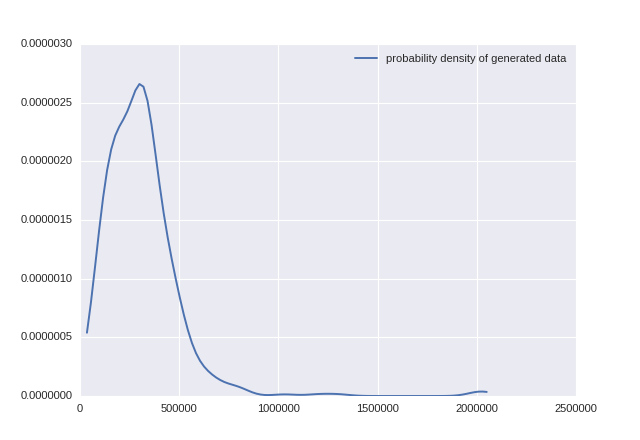

In [129]:
plt.close()
sns.distplot(y_test,hist=False,label='probability density of generated data')

In [130]:
class Heavy_tail_ridge(Ridge):
    def __init__(self, alpha=1.0, fit_intercept=True, normalize=False,
                 copy_X=True, max_iter=None, tol=1e-3, solver="auto",
                 random_state=None, delta = 0.2, c = 5):
        
        self.alpha = alpha
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.copy_X = copy_X
        self.max_iter = max_iter
        self.tol = tol
        self.solver = solver
        self.random_state = random_state
        self.delta = delta
        self.c = c
        self.models = []
        self.num_of_samples = 0
        
    def fit(self,X,y):
        ridge = Ridge(self.alpha, self.fit_intercept, self.normalize,
                 self.copy_X, self.max_iter, self.tol, self.solver,
                 self.random_state)
        #self.num_of_samples = np.ceil(self.c * np.log(1/self.delta))
        self.num_of_samples = 7
        print self.num_of_samples
        X_samples, y_samples = self._get_samples(X,y,self.num_of_samples)
        sample_size = np.floor(X.shape[0]/self.num_of_samples)
        for i in range(len(X_samples)):
            clf = ridge.fit(X_samples[i],y_samples[i])
            self.models.append(clf)
        return self
    
    def predict(self,X,y):
        model_w_vectors = []
        covariance_factor = []
        medians = []
        X_samples, y_samples = self._get_samples(X,y,self.num_of_samples)
        sample_size = np.floor(X.shape[0]/self.num_of_samples)
        for i in range(len(X_samples)):
            predictions = self.models[i].predict(X_samples[i])
            model_w_vectors.append(self.models[i].coef_)
            covariance_factor.append((1/(X_samples[i].shape[0])) * (np.vdot(X_samples[i],X_samples[i])))
        for i in range(len(self.models)):
            dist_list = []
            for j in range(len(self.models)):
                if (i == j):
                    continue
                else:
                    distance_vector = model_w_vectors[i] - model_w_vectors[j]
                    cov = covariance_factor[j] + self.alpha
                    distance = cov * np.vdot(distance_vector,distance_vector)
                    dist_list.append(distance)
            medians.append(np.median(dist_list))
                    
        least_median_idx = np.argmin(medians)
        w = model_w_vectors[least_median_idx]
        return np.dot(X,w.T)
    
    def _get_samples(self,X,y,num_of_samples):
        X, y = self._shuffle_data(X,y)
        instances = y.shape[0]
        extras = instances % num_of_samples
        if (extras != 0):
            X = X[:instances - extras,:]
            y = y[:instances - extras,:]
        return np.split(X,num_of_samples), np.split(y,num_of_samples)
        
    def _shuffle_data(self,X,y):
        permutation = np.random.permutation(X.shape[0])
        X_shuffled = X[permutation]
        y_shuffled = y[permutation]
        return X_shuffled,y_shuffled
    
    def score(self, X, y, sample_weight=None):
        return r2_score(y, self.predict(X,y), sample_weight=sample_weight,
                        multioutput='variance_weighted')

        

In [131]:
clf = Heavy_tail_ridge()

In [132]:
clf.fit(X_train,y_train)

7


Heavy_tail_ridge(alpha=1.0, c=5, copy_X=True, delta=0.2, fit_intercept=True,
         max_iter=None, normalize=False, random_state=None, solver='auto',
         tol=0.001)

In [133]:
len(clf.models)

7

<IPython.core.display.Javascript object>


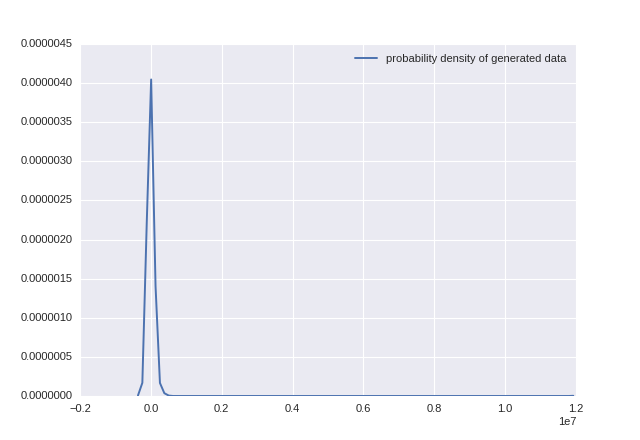

In [137]:
plt.close()
s = clf.predict(X_train,y_train)

sns.distplot(s,hist=False,label='probability density of generated data')

In [138]:
clf.score(X_test,y_test)

-2.2894726371009466

In [139]:
print s

[[  21204.62818455]
 [-148902.274088  ]
 [  -9679.46739586]
 ..., 
 [ -43585.82721202]
 [ -15758.47546297]
 [ 132470.82737112]]


In [140]:
for i in range(len(s)):
    print "predicted: ", s[i] , "  actual: ", y_test[i]

predicted:  [ 21204.62818455]   actual:  [ 315000.]
predicted:  [-148902.274088]   actual:  [ 380000.]
predicted:  [-9679.46739586]   actual:  [ 565000.]
predicted:  [ 77495.48462651]   actual:  [ 255000.]
predicted:  [-142667.38695212]   actual:  [ 340000.]
predicted:  [-89752.49174456]   actual:  [ 115000.]
predicted:  [ 121112.1197604]   actual:  [ 150000.]
predicted:  [-48774.12619031]   actual:  [ 265000.]
predicted:  [ 81590.78532979]   actual:  [ 480000.]
predicted:  [-87875.92982975]   actual:  [ 300000.]
predicted:  [-16100.87587982]   actual:  [ 180000.]
predicted:  [-805.84981629]   actual:  [ 40000.]
predicted:  [-123192.99241853]   actual:  [ 120000.]
predicted:  [ 43830.76011947]   actual:  [ 240000.]
predicted:  [-122386.75434147]   actual:  [ 315000.]
predicted:  [-101496.80313934]   actual:  [ 150000.]
predicted:  [-121572.08521343]   actual:  [ 210000.]
predicted:  [-35870.0346881]   actual:  [ 200000.]
predicted:  [ 98527.71151843]   actual:  [ 480000.]
predicted:  [

IndexError: index 500 is out of bounds for axis 0 with size 500